In [1]:
%matplotlib inline

import sys
sys.path.append("../../ee595")
sys.path.append("../../IntegratedGradients")

import numpy as np
from deepsea import *

import seaborn as sns
import matplotlib.pyplot as plt

from IntegratedGradients import integrated_gradients
from keras.models import load_model

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5005)


In [4]:
# data loading
test_X, test_Y = loaddata("../../ee595/data/deepsea/", "test")
train_X, train_Y = loaddata("../../ee595/data/deepsea/", "train")
valid_X, valid_Y = loaddata("../../ee595/data/deepsea/", "valid")

NameError: name 'loaddata' is not defined

In [2]:
# get sample positions

temp = [i.rstrip().split("\t") for i in open("../allTFs.pos.bed").readlines()]
positions = [[i[0], int(i[1]), int(i[2]), i[3], i[4], i[5]] for i in temp]

In [3]:
# divide them into test valid train sets. 

trainpos = positions[0:2200000]
validpos = positions[2200000:2204000]
testpos = [i for i in positions[2204000:] if i[0] == "chr8" or i[0] == "chr9"]

In [4]:
# get which outputnode maps to GM12878, CTCF

description = [(i.split("\t")[2], i.split("\t")[1]) for i in open("../../ee595/data/deepsea/features.txt").readlines()[1:-1]]
indexes = [i for i in range(len(description)) if description[i][1] == "K562"]
print description[indexes[1]]

('CTCF', 'K562')


In [5]:
# hg 19 contigs

names = ["chr10","chr11","chr12","chr13","chr14","chr15","chr16","chr17_ctg5_hap1",
 "chr17","chr18","chr19","chr1","chr20","chr21","chr22","chr2","chr3","chr4_ctg9_hap1",
 "chr4","chr5","chr6_apd_hap1","chr6_cox_hap2","chr6_dbb_hap3","chr6","chr6_mann_hap4",
 "chr6_mcf_hap5","chr6_qbl_hap6","chr6_ssto_hap7","chr7","chr8","chr9","chrM","chrUn_gl000211",
 "chrUn_gl000212","chrUn_gl000213","chrUn_gl000214","chrUn_gl000215","chrUn_gl000216","chrUn_gl000217",
 "chrUn_gl000218","chrUn_gl000219","chrUn_gl000220","chrUn_gl000221","chrUn_gl000222","chrUn_gl000223",
 "chrUn_gl000224","chrUn_gl000225","chrUn_gl000226","chrUn_gl000227","chrUn_gl000228","chrUn_gl000229",
 "chrUn_gl000230","chrUn_gl000231","chrUn_gl000232","chrUn_gl000233","chrUn_gl000234","chrUn_gl000235",
 "chrUn_gl000236","chrUn_gl000237","chrUn_gl000238","chrUn_gl000239","chrUn_gl000240","chrUn_gl000241",
 "chrUn_gl000242","chrUn_gl000243","chrUn_gl000244",
 "chrUn_gl000245","chrUn_gl000246","chrUn_gl000247","chrUn_gl000248","chrUn_gl000249","chrX","chrY"]

sizes = [135534747,135006516,133851895,115169878,107349540,102531392,90354753,1680828,81195210,78077248,
         59128983,249250621,63025520,48129895,51304566,243199373,198022430,590426,191154276,180915260,4622290,
         4795371,4610396,171115067,4683263,4833398,4611984,4928567,159138663,146364022,141213431,16571,166566,
         186858,164239,137718,172545,172294,172149,161147,179198,161802,155397,186861,180455,179693,211173,15008,
         128374,129120,19913,43691,27386,40652,45941,40531,34474,41934,45867,39939,33824,41933,42152,43523,43341,
         39929,36651,38154,36422,39786,38502,155270560,59373566]

contigs = dict([(names[i], sizes[i]) for i in range(len(sizes))])

In [6]:
def loadarray(fileprefix, size):
    index = np.genfromtxt(fileprefix+"_index.csv", dtype=int)
    values = np.genfromtxt(fileprefix+"_values.csv", dtype=int)
    ret = np.zeros(size)
    for i in range(len(index)):
        ret[index[i]-1] = values[i]
    return ret

In [7]:
chroms = list(set([i[0] for i in positions]))

In [8]:
#Loading ATACseq read starts (hyperbolilc arcsine transformation)
atacdata = {}
chrommax = {}
for c in chroms:
    temp = loadarray("ATAC-fr-separated-GM12878/"+c+"f", contigs[c])
    atacdata[c+"f"] = temp
    chrommax[c+"f"] = np.max(temp)
    
    temp = loadarray("ATAC-fr-separated-GM12878/"+c+"r", contigs[c])
    atacdata[c+"r"] = temp
    chrommax[c+"r"] = np.max(temp)

    print c, ", AVG asinh transformed coverage:", np.max(temp)

chrY , AVG asinh transformed coverage: 11610.0
chrX , AVG asinh transformed coverage: 29234.0
chr13 , AVG asinh transformed coverage: 41443.0
chr12 , AVG asinh transformed coverage: 27789.0
chr11 , AVG asinh transformed coverage: 88846.0
chr10 , AVG asinh transformed coverage: 726.0
chr17 , AVG asinh transformed coverage: 52923.0
chr16 , AVG asinh transformed coverage: 221.0
chr15 , AVG asinh transformed coverage: 126.0
chr14 , AVG asinh transformed coverage: 23142.0
chr19 , AVG asinh transformed coverage: 856.0
chr18 , AVG asinh transformed coverage: 38467.0
chr22 , AVG asinh transformed coverage: 393.0
chr20 , AVG asinh transformed coverage: 1258.0
chr21 , AVG asinh transformed coverage: 4341.0
chr7 , AVG asinh transformed coverage: 55568.0
chr6 , AVG asinh transformed coverage: 28848.0
chr5 , AVG asinh transformed coverage: 51273.0
chr4 , AVG asinh transformed coverage: 25392.0
chr3 , AVG asinh transformed coverage: 40475.0
chr2 , AVG asinh transformed coverage: 54672.0
chr1 , AVG a

In [9]:
atactrain = [] 
for i in trainpos:
    temp1 = atacdata[i[0]+"f"][i[1]:i[2]].reshape((200,1))
    temp2 = atacdata[i[0]+"r"][i[1]:i[2]].reshape((200,1))

    sample = np.concatenate([temp1, temp2], axis=1)
    sample = np.arcsinh(sample)/np.arcsinh(max(chrommax[i[0]+"f"],chrommax[i[0]+"r"]))
    atactrain.append(sample)
atactrain = np.array(atactrain)

In [10]:
atactest = [] 
for i in testpos:
    temp1 = atacdata[i[0]+"f"][i[1]:i[2]].reshape((200,1))
    temp2 = atacdata[i[0]+"r"][i[1]:i[2]].reshape((200,1))

    sample = np.concatenate([temp1, temp2], axis=1)
    sample = np.arcsinh(sample)/np.arcsinh(max(chrommax[i[0]+"f"],chrommax[i[0]+"r"]))
    atactest.append(sample)
atactest = np.array(atactest)

In [11]:
atacvalid = [] 
for i in validpos:
    temp1 = atacdata[i[0]+"f"][i[1]:i[2]].reshape((200,1))
    temp2 = atacdata[i[0]+"r"][i[1]:i[2]].reshape((200,1))

    sample = np.concatenate([temp1, temp2], axis=1)
    sample = np.arcsinh(sample)/np.arcsinh(max(chrommax[i[0]+"f"],chrommax[i[0]+"r"]))
    atacvalid.append(sample)
atacvalid = np.array(atacvalid)

In [12]:
atactest.shape

(227512, 200, 2)

In [13]:
np.save("atactrain2", atactrain)

In [14]:
np.save("atacvalid2", atacvalid)

In [15]:
np.save("atactest2", atactest)

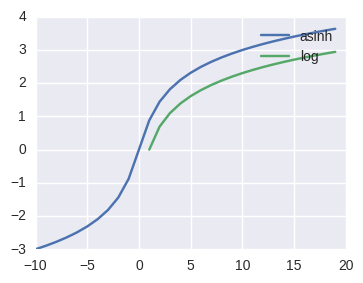

In [27]:
# Sample distribution of asinh and log transformation 

plt.figure(figsize=(4,3))
m = 20
plt.plot(range(-10, m), np.arcsinh(range(-10, m)), label="asinh")
plt.plot(range(-10, m), np.log(range(-10, m)), label="log")
plt.legend()

# visualization

In [16]:
raw = [i.rstrip().split("\t") for i in open("../rawdata/greenleaf-pooled/footprints/output.sorted.bam.output.bed.WellingtonFootprints.FDR.0.01.bed")]

In [19]:
wellington_footprints = [[i[0], int(i[1]), int(i[2]), i[3], float(i[4]), i[5]] for i in raw]

In [26]:
wellington_footprints.sort(key=lambda x:x[4])

chr10 42380267 42380292
chr18 18519861 18519886
chr18 18520298 18520317
chr19 27732053 27732072
chr19 27732084 27732097
chr19 27732218 27732243
chr4 68265308 68265333
chr5 105889153 105889176
chr8 43095215 43095238
chr10 42529598 42529623


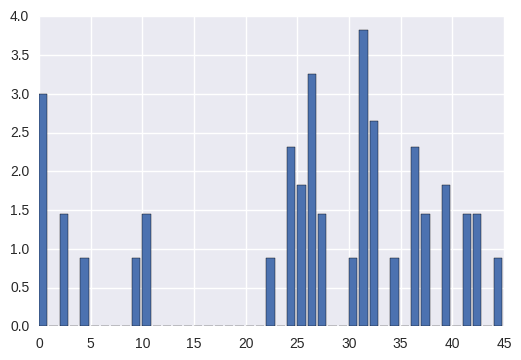

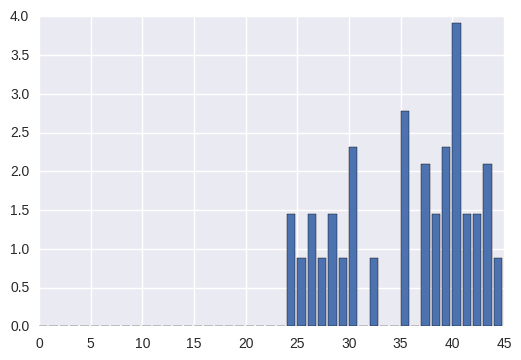

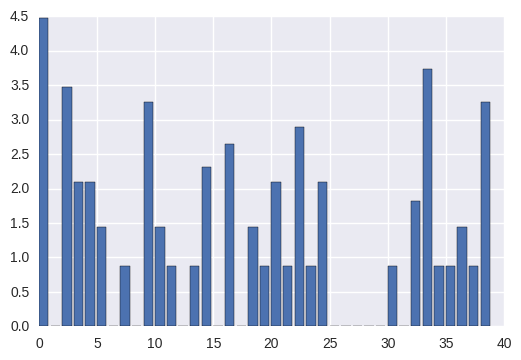

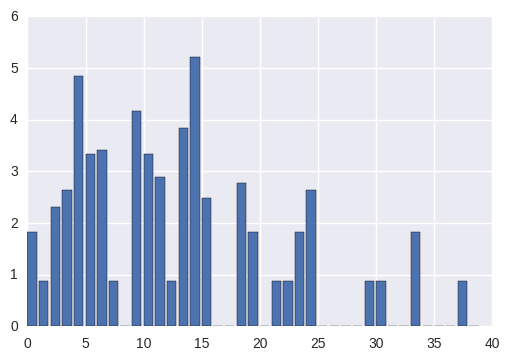

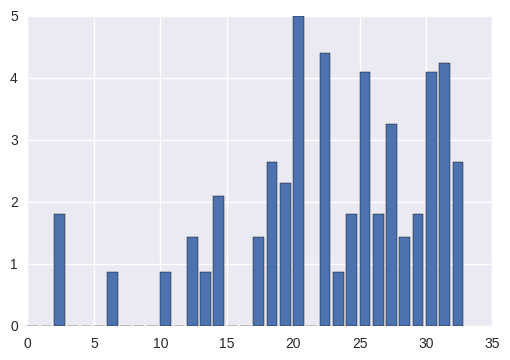

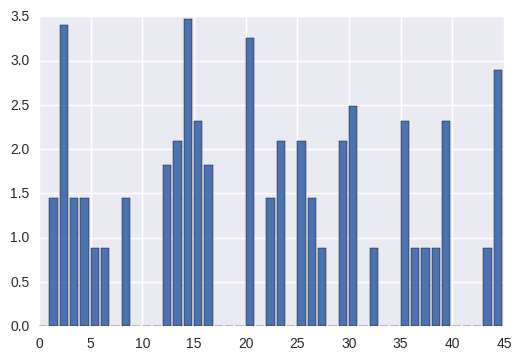

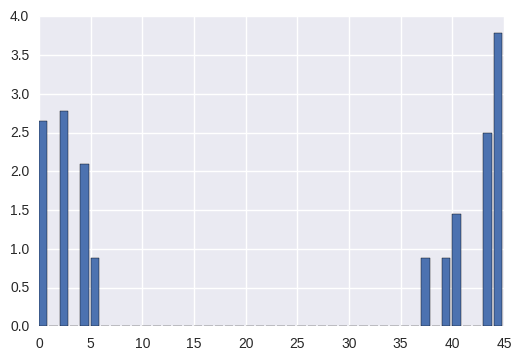

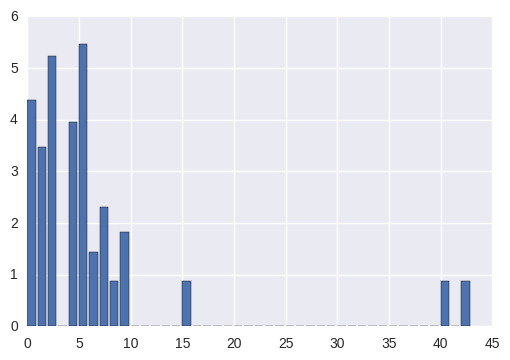

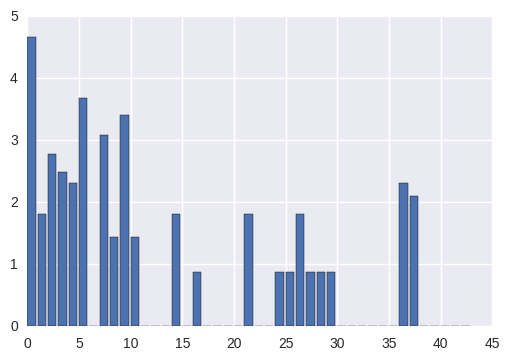

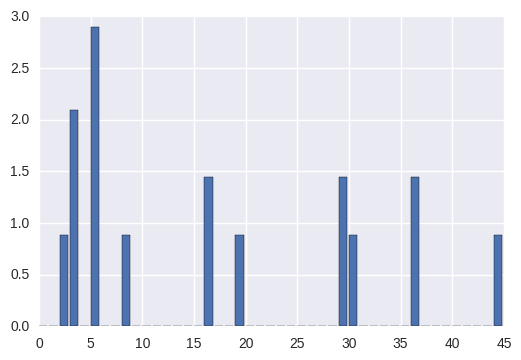

In [32]:
window = 10
for i in range(10):
    ft = wellington_footprints[i]
    chrom = ft[0]
    start = ft[1]
    end = ft[2]
    
    content = atacdata[chrom][start-window:end+window]
    plt.figure()
    plt.bar(range(len(content)), content)

chr1
chr1
chr11
chr11
chr11
chr11
chr11
chr13
chr2
chr2
chr3


/home/hiranumn/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


chr3
chr4
chr5
chr5
chr6
chr6


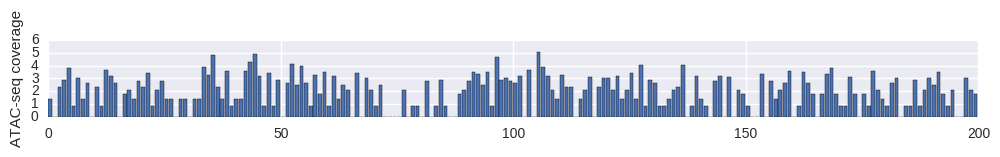

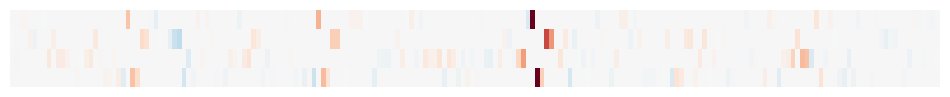

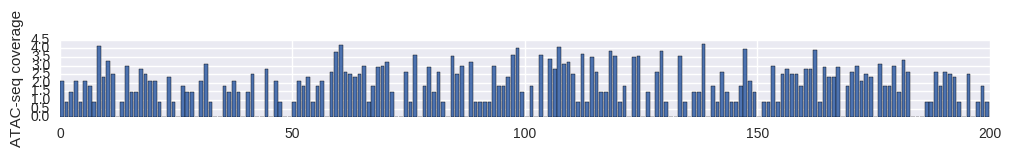

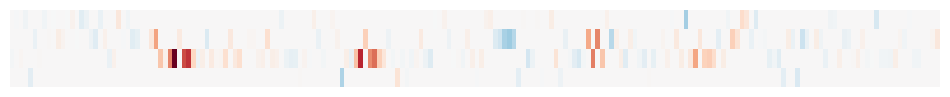

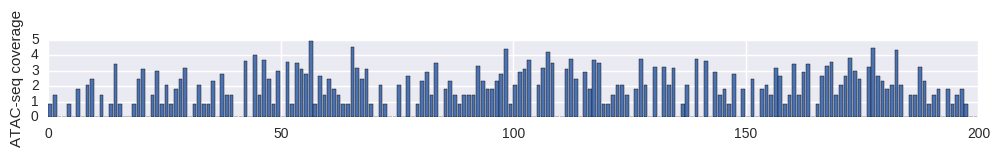

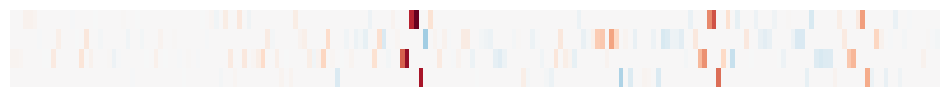

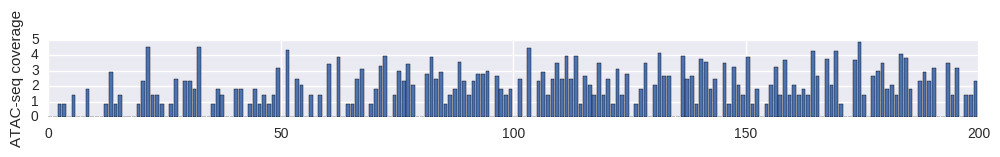

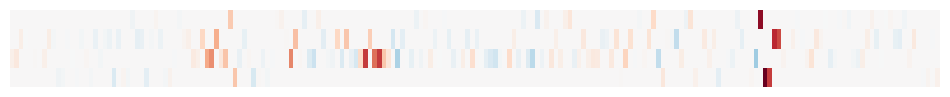

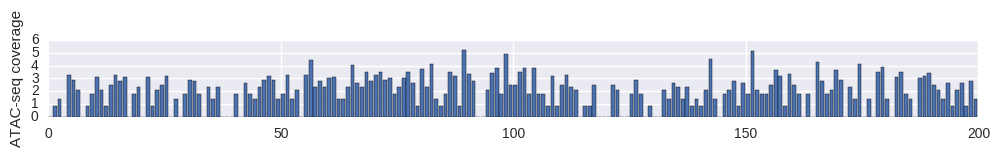

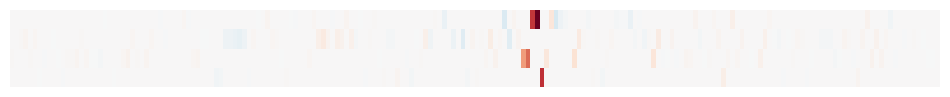

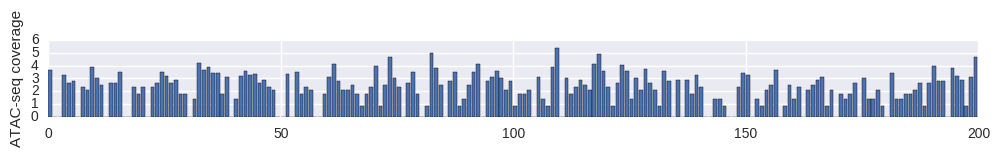

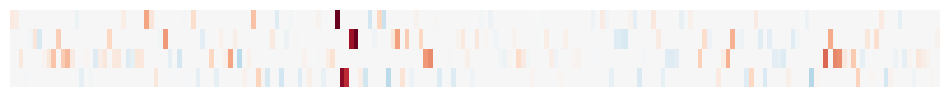

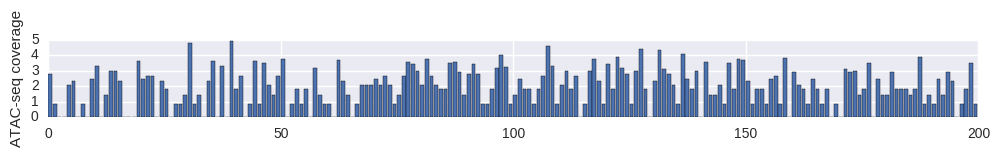

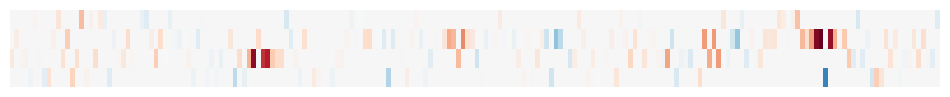

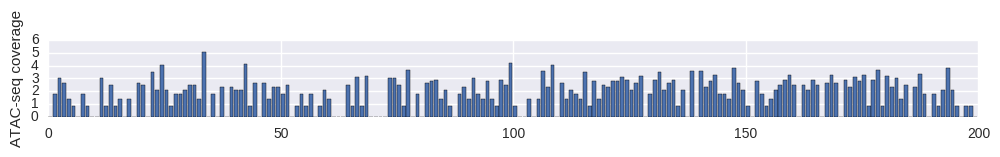

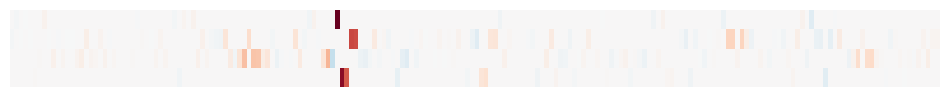

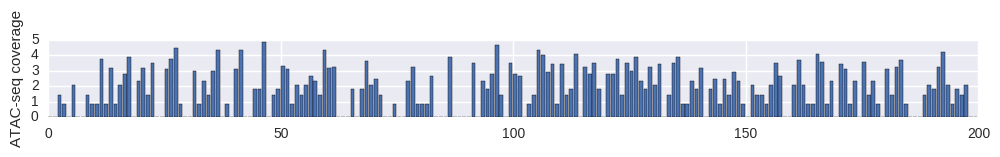

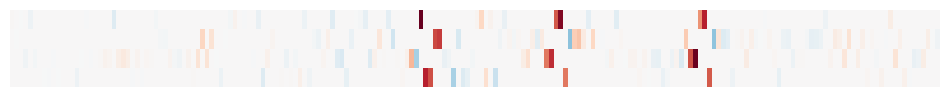

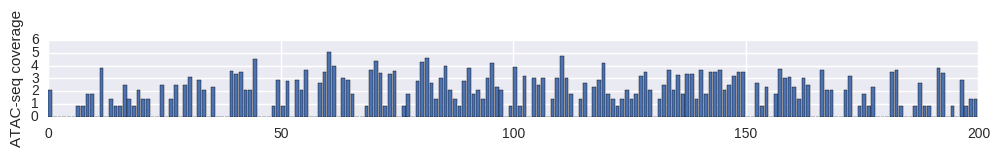

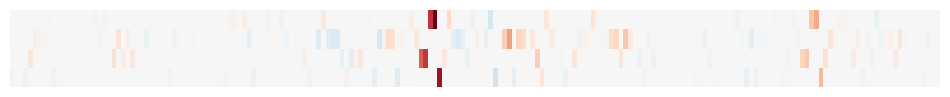

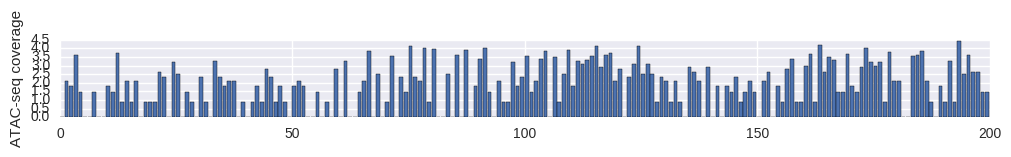

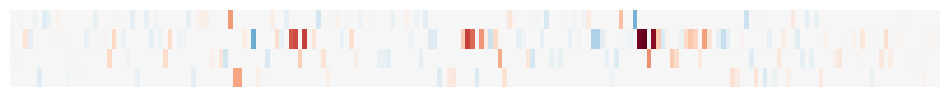

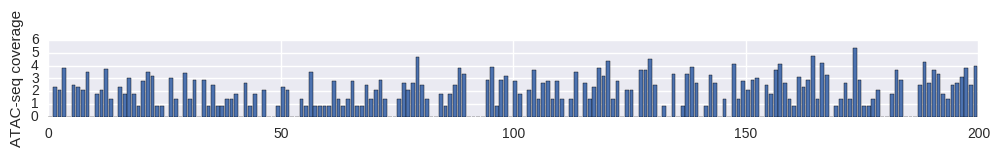

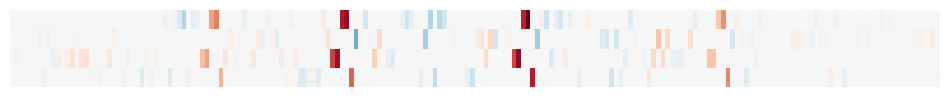

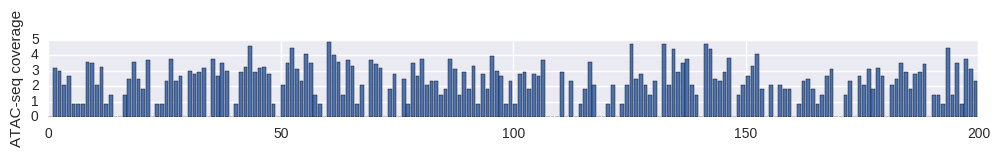

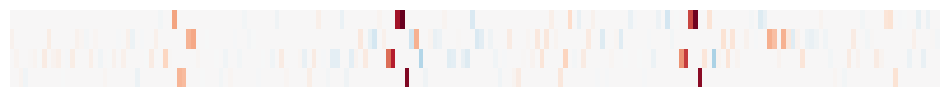

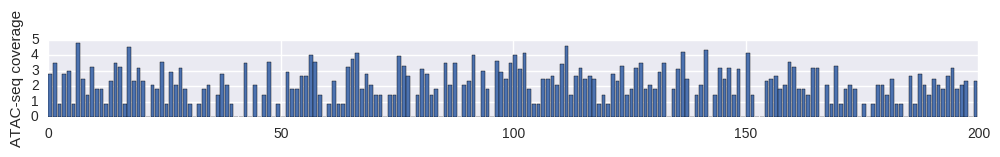

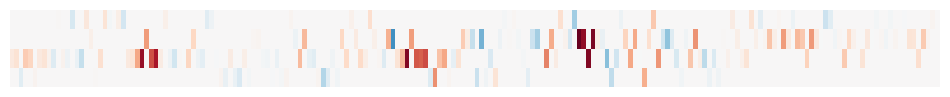

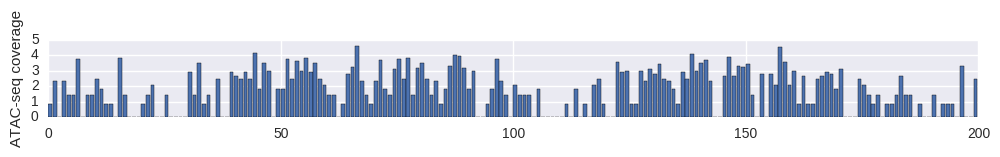

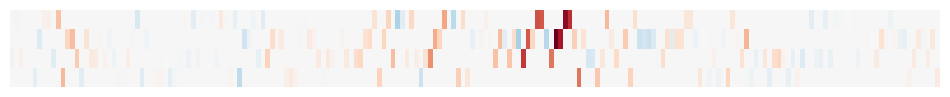

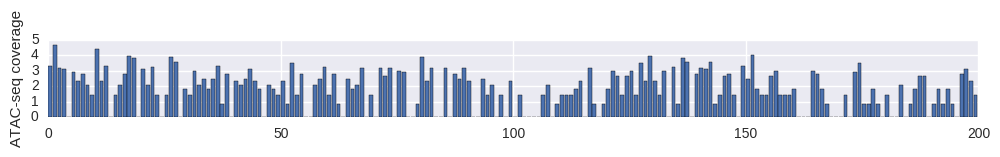

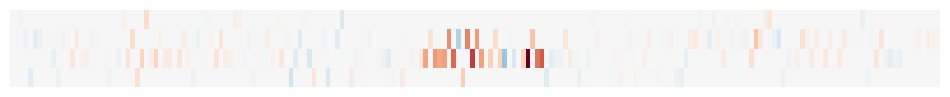

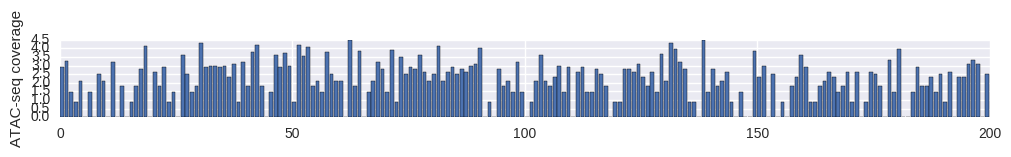

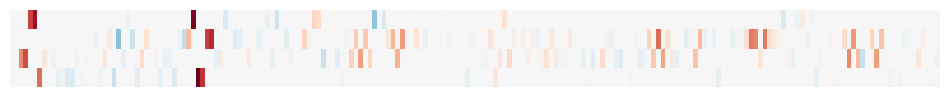

In [44]:
for i in index:
    pos = trainpos[i]
    if sum(atacdata[pos[0]][pos[1]:pos[2]]) > 350:
        plt.figure(figsize=(12,1))
        plt.ylabel("ATAC-seq coverage")
        plt.bar(range(200), atacdata[pos[0]][pos[1]:pos[2]])
        ex = ig.explain(train_X[i])[0][400:600]
        plt.figure(figsize=(12,1))
        sns.heatmap(np.transpose(ex), cbar=False)
        plt.yticks([],[])
        plt.xticks([],[])